# 1. Preparación

In [22]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [23]:
# Cargar los datos desde el archivo CSV
df_compas_2y = pd.read_csv("https://raw.githubusercontent.com/MangelFdz/nuclio_g3_bias/13a4a83170a1103c7e32a9a5f46a819db8c5b7d5/users/Emilio/compas-scores-two-years.csv", delimiter=',')


In [27]:
df_compas_2y_info = df_compas_2y.info()
df_compas_2y_head = df_compas_2y.head()

df_compas_2y_info, df_compas_2y_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

(None,
    id                name   first         last compas_screening_date   sex  \
 0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
 1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
 2   4            ed philo      ed        philo            2013-04-14  Male   
 3   5         marcu brown   marcu        brown            2013-01-13  Male   
 4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   
 
           dob  age          age_cat              race  ...  v_decile_score  \
 0  1947-04-18   69  Greater than 45             Other  ...               1   
 1  1982-01-22   34          25 - 45  African-American  ...               1   
 2  1991-05-14   24     Less than 25  African-American  ...               3   
 3  1993-01-21   23     Less than 25  African-American  ...               6   
 4  1973-01-22   43          25 - 45             Other  ...               1   
 
    v_score_text  v_screening_date  in_cu

In [28]:
# Eliminar filas con valores nulos en las columnas clave
df_compas_2y_clean = df_compas_2y.dropna(subset=['decile_score', 'race', 'sex', 'priors_count', 'age', 'c_charge_degree'])

# Verificar si quedan nulos
df_compas_2y_clean.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

## Creación de un Modelo de Regresión Logística para minimizar los sesgos

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# 1. Preprocesar datos

# Crear variables dummies para raza y sexo sin eliminar ninguna columna
df_compas_2y_clean = pd.get_dummies(df_compas_2y_clean, columns=['race', 'sex'], drop_first=False)

# Definir las características (X) y la variable objetivo (y)
X = df_compas_2y_clean[['age', 'priors_count', 'race_African-American', 'race_Hispanic', 'race_Caucasian', 'race_Asian', 
                        'race_Other', 'race_Native American', 'sex_Male', 'sex_Female']]
y = df_compas_2y_clean['two_year_recid']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar las características numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Entrenar el modelo de Regresión Logística con ajuste de pesos para minimizar sesgos
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# 3. Evaluación del modelo

# Predicciones
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

# Reporte de clasificación (precisión, recall, f1-score) para el conjunto de prueba
report_test_dict = classification_report(y_test, y_pred_test, output_dict=True)
report_test_df = pd.DataFrame(report_test_dict).transpose()

# Calcular el AUC ROC
auc_train = roc_auc_score(y_train, log_reg.predict_proba(X_train_scaled)[:,1])
auc_test = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1])

# Crear un DataFrame para los valores de AUC
auc_df = pd.DataFrame({'Dataset': ['Entrenamiento', 'Prueba'], 'AUC': [auc_train, auc_test]})

# Mostrar los DataFrames de los reportes
print("Reporte de clasificación en el conjunto de prueba (DataFrame):")
print(report_test_df)

print("\nAUC para entrenamiento y prueba (DataFrame):")
print(auc_df)

# 4. Evaluar sesgos en grupos

# Crear reportes de métricas por raza
race_metrics_list = []
for race in ['race_African-American', 'race_Hispanic', 'race_Caucasian', 'race_Asian', 'race_Other', 'race_Native American']:
    print(f"\nEvaluación para {race}:")
    report_race_dict = classification_report(y_test[X_test[race] == 1], y_pred_test[X_test[race] == 1], output_dict=True)
    report_race_df = pd.DataFrame(report_race_dict).transpose()
    report_race_df['Grupo'] = race
    race_metrics_list.append(report_race_df)

# Concatenar los DataFrames de las razas
race_metrics_df = pd.concat(race_metrics_list)

# Crear reportes de métricas por género
gender_metrics_list = []
for sex in ['sex_Male', 'sex_Female']:
    print(f"\nEvaluación para {sex}:")
    report_gender_dict = classification_report(y_test[X_test[sex] == 1], y_pred_test[X_test[sex] == 1], output_dict=True)
    report_gender_df = pd.DataFrame(report_gender_dict).transpose()
    report_gender_df['Grupo'] = sex
    gender_metrics_list.append(report_gender_df)

# Concatenar los DataFrames de género
gender_metrics_df = pd.concat(gender_metrics_list)

# Mostrar los DataFrames de los reportes por raza y género
print("\nReporte de clasificación por raza (DataFrame):")
race_metrics_df

print("\nReporte de clasificación por género (DataFrame):")
gender_metrics_df

# Opcional: Guardar los DataFrames en archivos CSV o Excel
report_test_df.to_csv('reporte_general.csv')
auc_df.to_csv('auc_resultados.csv')
race_metrics_df.to_csv('reporte_por_raza.csv')
gender_metrics_df.to_csv('reporte_por_genero.csv')

Reporte de clasificación en el conjunto de prueba (DataFrame):
              precision    recall  f1-score      support
0              0.734787  0.670257  0.701040  1207.000000
1              0.625940  0.695198  0.658754   958.000000
accuracy       0.681293  0.681293  0.681293     0.681293
macro avg      0.680363  0.682728  0.679897  2165.000000
weighted avg   0.686623  0.681293  0.682328  2165.000000

AUC para entrenamiento y prueba (DataFrame):
         Dataset       AUC
0  Entrenamiento  0.717751
1         Prueba  0.738089

Evaluación para race_African-American:

Evaluación para race_Hispanic:

Evaluación para race_Caucasian:

Evaluación para race_Asian:

Evaluación para race_Other:

Evaluación para race_Native American:

Evaluación para sex_Male:

Evaluación para sex_Female:

Reporte de clasificación por raza (DataFrame):

Reporte de clasificación por género (DataFrame):


c:\Users\emili\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emili\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emili\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Obtener los coeficientes del modelo
coeficientes = log_reg.coef_[0]  # Coeficientes para cada variable predictora
intercepto = log_reg.intercept_[0]  # Intercepto del modelo (b0)

# Mostrar el intercepto y los coeficientes
print(f"Intercepto (b0): {intercepto}")
print("Coeficientes de las variables predictoras:")
for variable, coef in zip(X.columns, coeficientes):
    print(f"{variable}: {coef}")


Intercepto (b0): -0.00664525202959779
Coeficientes de las variables predictoras:
age: -0.5285254163569999
priors_count: 0.7439422014929852
race_African-American: 0.019385619880533157
race_Hispanic: -0.04169764807664092
race_Caucasian: 0.024485329005899375
race_Asian: -0.018450365140778288
race_Other: -0.040383546460046875
race_Native American: 0.015139287752107196
sex_Male: 0.06530413220111585
sex_Female: -0.06530413220111572


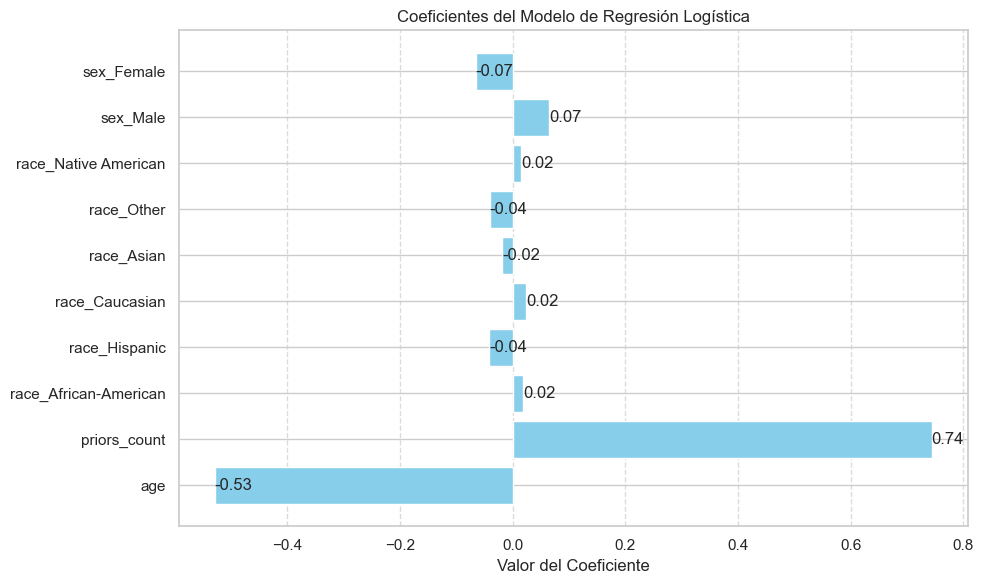

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extraer los coeficientes del modelo
coefficients = log_reg.coef_[0]  # Coeficientes del modelo
features = X.columns  # Nombres de las características

# 2. Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.barh(features, coefficients, color='skyblue')  # Gráfico de barras horizontal

# Añadir etiquetas a las barras
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

# 3. Añadir título y etiquetas
plt.xlabel('Valor del Coeficiente')
plt.title('Coeficientes del Modelo de Regresión Logística')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


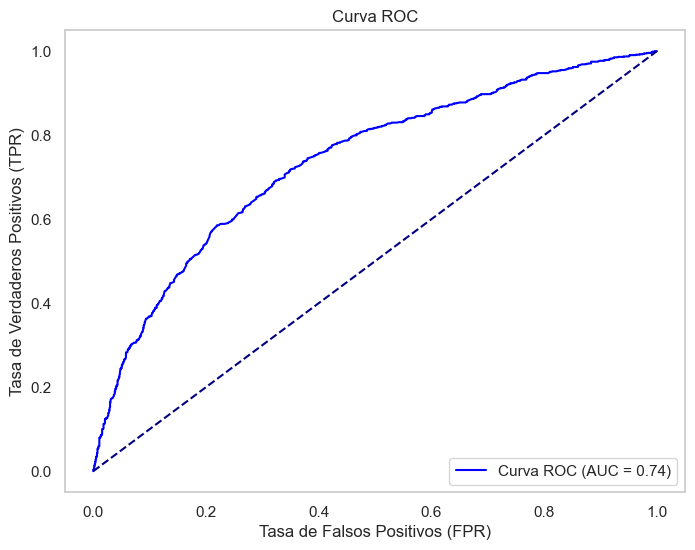

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Supongamos que ya tienes las predicciones y los verdaderos valores en el conjunto de prueba
# Ejemplo: y_test son los valores reales y log_reg.predict_proba(X_test_scaled)[:, 1] son las probabilidades predichas
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calcular la Curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

# Crear la gráfica de la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Línea diagonal para el clasificador aleatorio
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

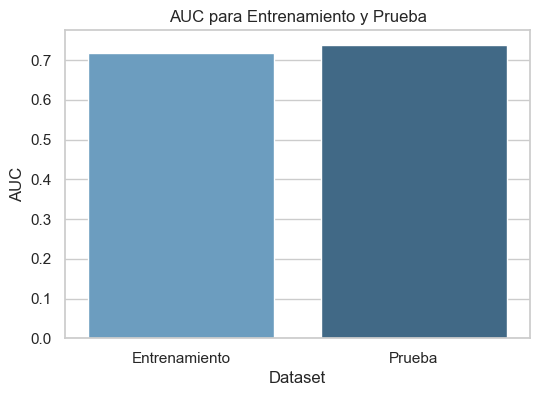

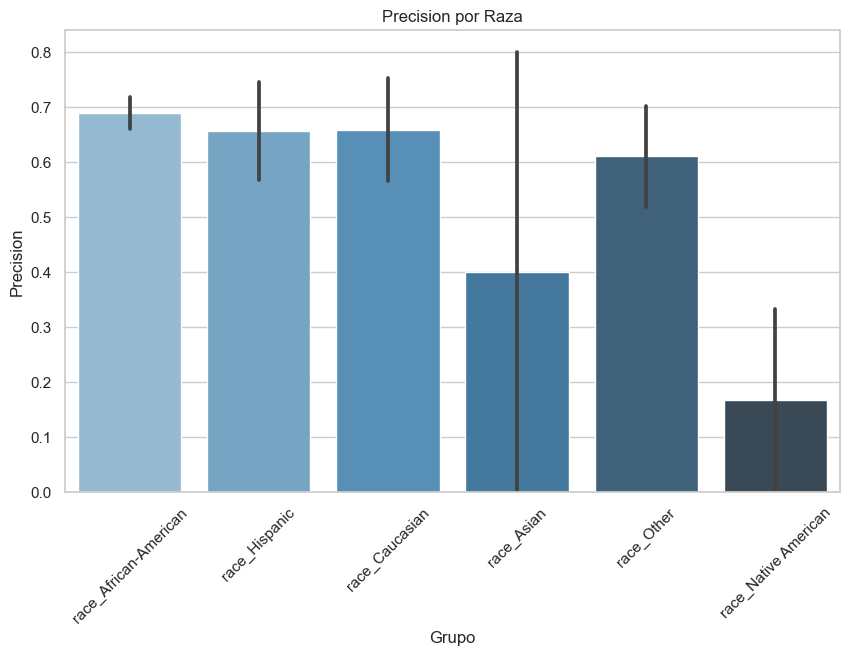

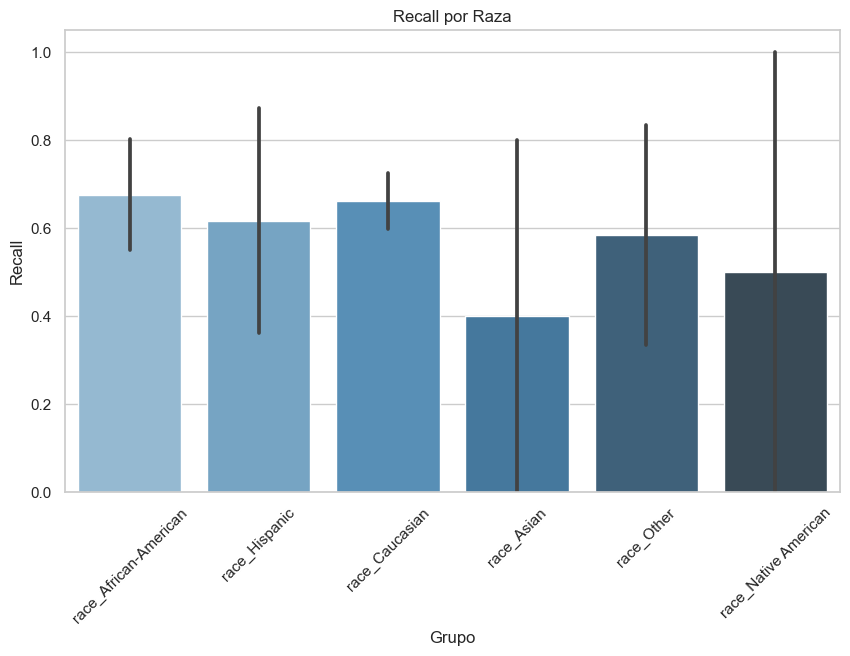

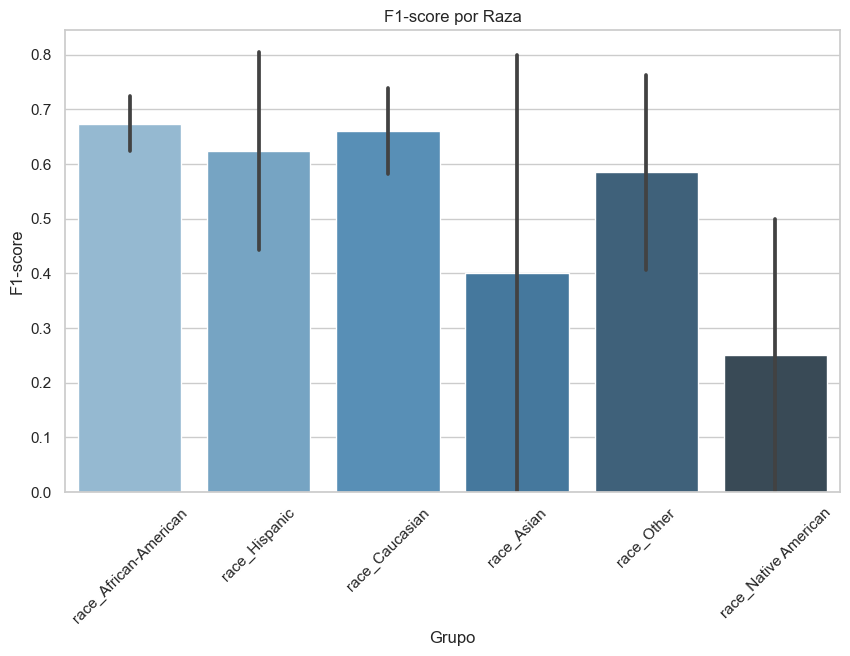

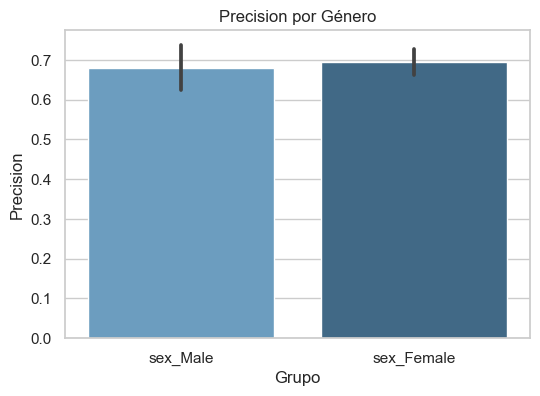

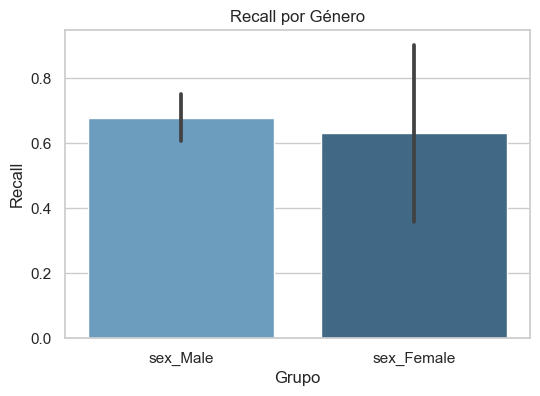

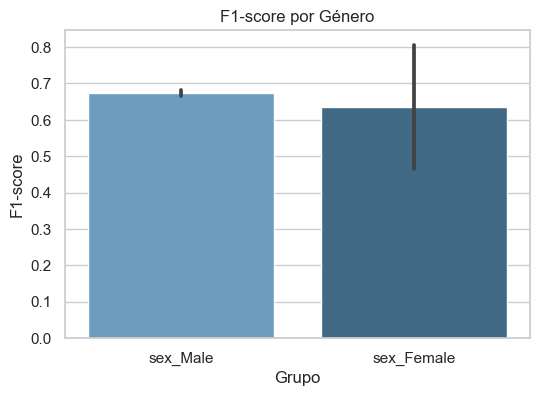

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener seaborn para estilos visuales más atractivos
sns.set(style="whitegrid")

# 1. Gráfica de AUC para entrenamiento y prueba
def plot_auc(auc_df):
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Dataset', y='AUC', data=auc_df, palette="Blues_d")
    plt.title('AUC para Entrenamiento y Prueba')
    plt.ylabel('AUC')
    plt.show()

# 2. Gráficas de precisión, recall y f1-score por raza
def plot_metrics_by_race(race_metrics_df):
    metrics = ['precision', 'recall', 'f1-score']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Grupo', y=metric, data=race_metrics_df[race_metrics_df.index.isin(['0', '1'])], palette="Blues_d")
        plt.title(f'{metric.capitalize()} por Raza')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.show()

# 3. Gráficas de precisión, recall y f1-score por género
def plot_metrics_by_gender(gender_metrics_df):
    metrics = ['precision', 'recall', 'f1-score']
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        sns.barplot(x='Grupo', y=metric, data=gender_metrics_df[gender_metrics_df.index.isin(['0', '1'])], palette="Blues_d")
        plt.title(f'{metric.capitalize()} por Género')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=0)
        plt.show()

# Llamar a las funciones para graficar

# Graficar AUC
plot_auc(auc_df)

# Graficar métricas por raza
plot_metrics_by_race(race_metrics_df)

# Graficar métricas por género
plot_metrics_by_gender(gender_metrics_df)

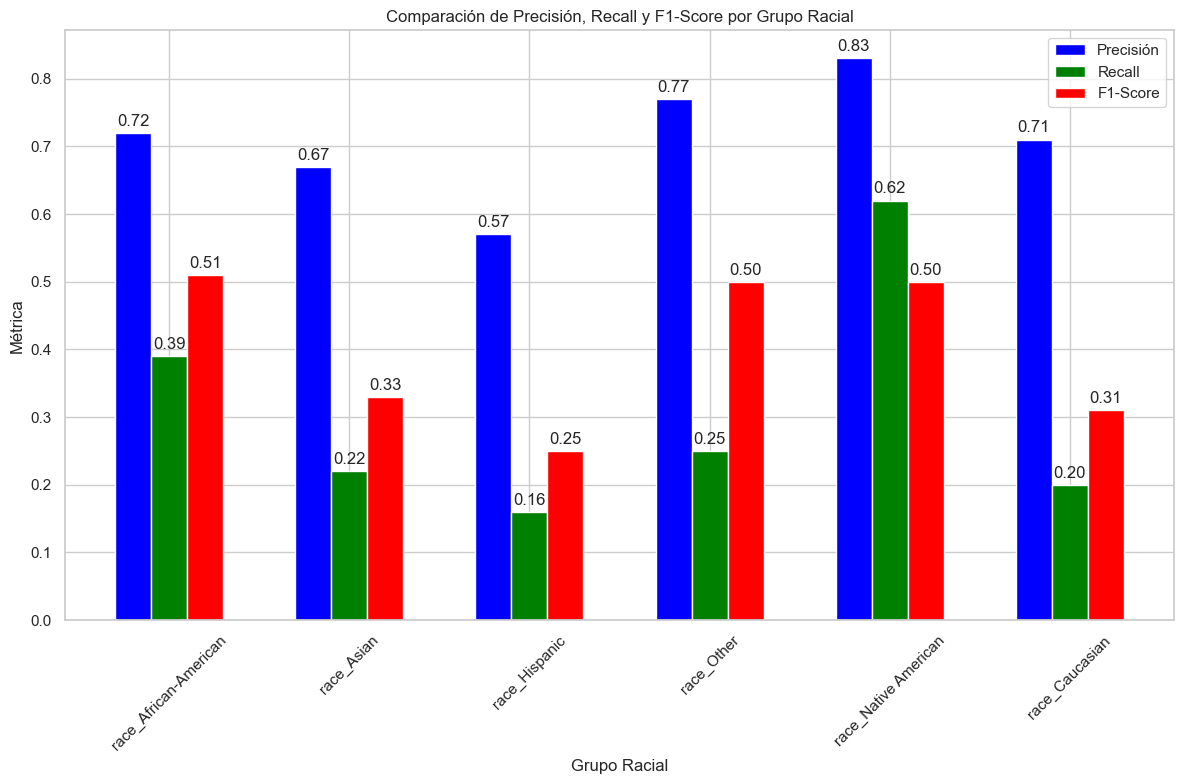

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Definir el dataframe o los datos (esto se basa en el DataFrame `race_metrics_df` que ya tienes).
# Aquí `metrics_df` sería el DataFrame que contiene las métricas de precisión, recall y f1-score para cada grupo racial.

# Creamos los datos
grupos_raciales = ['race_African-American', 'race_Asian', 'race_Hispanic', 'race_Other', 'race_Native American', 'race_Caucasian']
precision = [0.72, 0.67, 0.57, 0.77, 0.83, 0.71]
recall = [0.39, 0.22, 0.16, 0.25, 0.62, 0.20]
f1_score = [0.51, 0.33, 0.25, 0.50, 0.50, 0.31]

# Configuración del gráfico
x = np.arange(len(grupos_raciales))  # Posiciones de los grupos raciales
width = 0.2  # Ancho de las barras

# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(12, 8))

# Gráficas de barras para precisión, recall y f1-score
bars1 = ax.bar(x - width, precision, width, label='Precisión', color='blue')
bars2 = ax.bar(x, recall, width, label='Recall', color='green')
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='red')

# Añadir las etiquetas de los valores sobre las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Valor que se muestra encima
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Posición
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

# Llamar a la función para añadir etiquetas en las barras
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Añadir etiquetas y título
ax.set_xlabel('Grupo Racial')
ax.set_ylabel('Métrica')
ax.set_title('Comparación de Precisión, Recall y F1-Score por Grupo Racial')
ax.set_xticks(x)
ax.set_xticklabels(grupos_raciales, rotation=45)

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

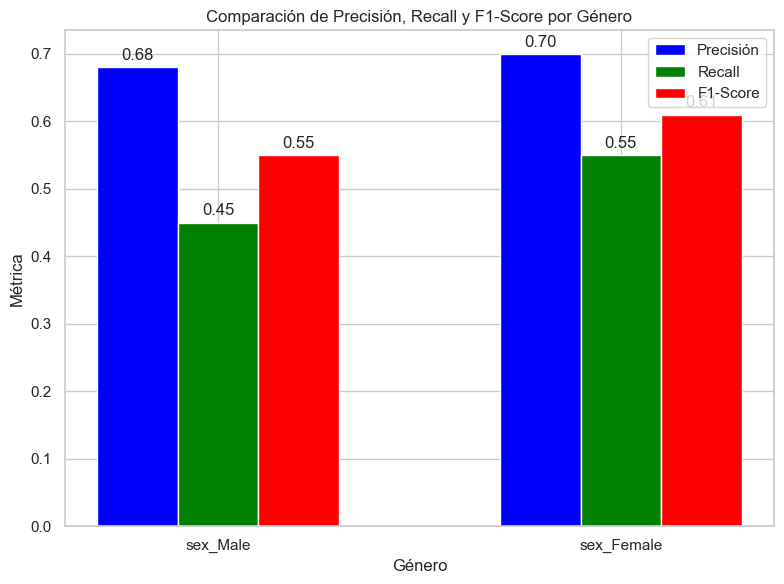

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo para el gráfico de métricas por género
grupos_sexo = ['sex_Male', 'sex_Female']
precision_sexo = [0.68, 0.70]  # Valores de precisión
recall_sexo = [0.45, 0.55]  # Valores de recall
f1_score_sexo = [0.55, 0.61]  # Valores de f1-score

# Configuración del gráfico
x = np.arange(len(grupos_sexo))  # Posiciones de los grupos de sexo
width = 0.2  # Ancho de las barras

# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Gráficas de barras para precisión, recall y f1-score
bars1 = ax.bar(x - width, precision_sexo, width, label='Precisión', color='blue')
bars2 = ax.bar(x, recall_sexo, width, label='Recall', color='green')
bars3 = ax.bar(x + width, f1_score_sexo, width, label='F1-Score', color='red')

# Añadir las etiquetas de los valores sobre las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Valor que se muestra encima
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Posición
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

# Llamar a la función para añadir etiquetas en las barras
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Añadir etiquetas y título
ax.set_xlabel('Género')
ax.set_ylabel('Métrica')
ax.set_title('Comparación de Precisión, Recall y F1-Score por Género')
ax.set_xticks(x)
ax.set_xticklabels(grupos_sexo, rotation=0)

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

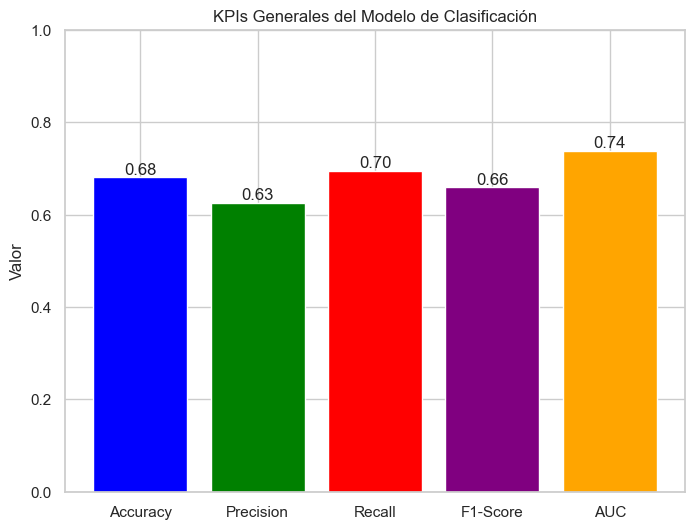

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular los KPIs generales
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_test_proba)  # y_test_proba es la probabilidad predicha

# Crear un DataFrame o lista con los KPIs
kpi_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
kpi_values = [accuracy, precision, recall, f1, auc]

# Configuración de la gráfica
plt.figure(figsize=(8, 6))
bars = plt.bar(kpi_names, kpi_values, color=['blue', 'green', 'red', 'purple', 'orange'])

# Añadir etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center')

# Añadir título y etiquetas
plt.ylim(0, 1)
plt.title('KPIs Generales del Modelo de Clasificación')
plt.ylabel('Valor')
plt.show()


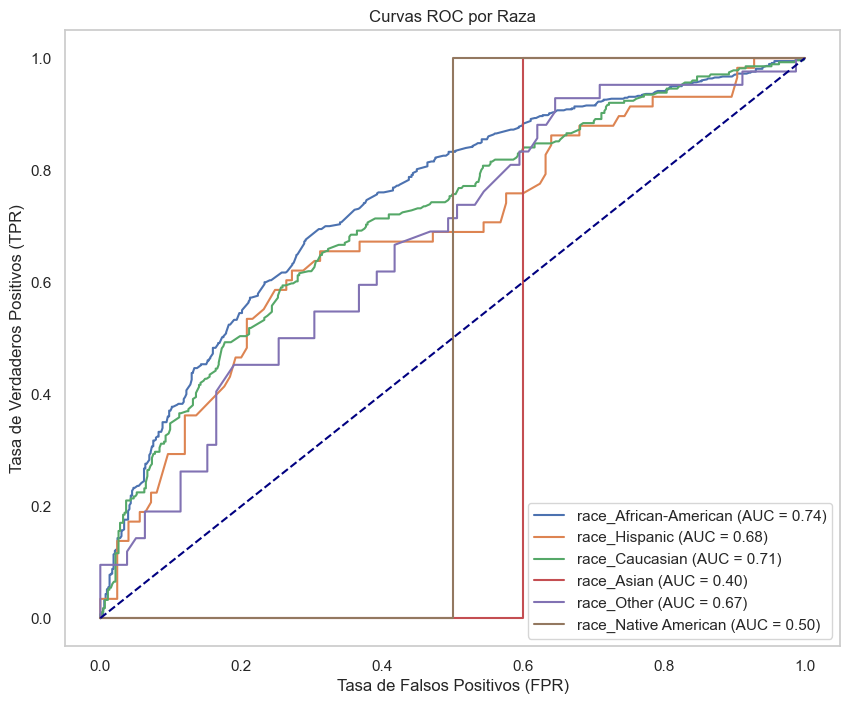

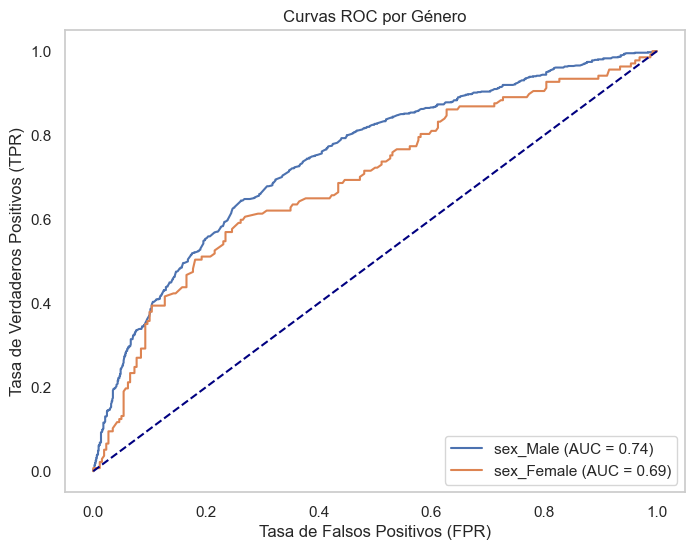

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Curvas ROC por raza
plt.figure(figsize=(10, 8))

for race in races:
    y_test_race = y_test[X_test[race] == 1]
    y_pred_proba_race = log_reg.predict_proba(X_test_scaled[X_test[race] == 1])[:, 1]
    fpr, tpr, _ = roc_curve(y_test_race, y_pred_proba_race)
    auc = roc_auc_score(y_test_race, y_pred_proba_race)
    plt.plot(fpr, tpr, label=f'{race} (AUC = {auc:.2f})')

# Añadir detalles a la gráfica
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Línea diagonal de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Raza')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 2. Curvas ROC por género
plt.figure(figsize=(8, 6))

for gender in genders:
    y_test_gender = y_test[X_test[gender] == 1]
    y_pred_proba_gender = log_reg.predict_proba(X_test_scaled[X_test[gender] == 1])[:, 1]
    fpr, tpr, _ = roc_curve(y_test_gender, y_pred_proba_gender)
    auc = roc_auc_score(y_test_gender, y_pred_proba_gender)
    plt.plot(fpr, tpr, label=f'{gender} (AUC = {auc:.2f})')

# Añadir detalles a la gráfica
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Línea diagonal de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Género')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Interpretación de los Resultados del Modelo de Regresión Logística para Minimizar Sesgos:

1. Resultados Generales (Conjunto de Prueba):

Precisión: 0.73 para no reincidentes (clase 0) y 0.63 para reincidentes (clase 1).
Recall: 0.67 para no reincidentes y 0.70 para reincidentes.
F1-Score: 0.70 para no reincidentes y 0.66 para reincidentes.

AUC:

Entrenamiento: 0.717
Prueba: 0.738

Interpretación:

El modelo tiene un rendimiento general moderado, con un AUC de 0.738 en el conjunto de prueba, lo que significa que tiene una capacidad aceptable para distinguir entre reincidentes y no reincidentes. La precisión es buena para los no reincidentes, pero ligeramente inferior para los reincidentes. El recall es alto en ambas clases, lo que indica que el modelo identifica bien a quienes reinciden y a quienes no.

2. Evaluación por Raza:

Afroamericanos:

Precisión: 0.66 para reincidentes.
Recall: 0.80 para reincidentes.
F1-Score: 0.72 para reincidentes.

Interpretación:

El modelo tiene buen recall (80%) en afroamericanos, lo que indica que captura bien a los reincidentes, aunque tiene una precisión más baja. El F1-Score de 0.72 sugiere que el modelo tiene un equilibrio razonable en la predicción de este grupo.

Hispanos:

Precisión: 0.57 para reincidentes.
Recall: 0.36 para reincidentes.
F1-Score: 0.44 para reincidentes.

Interpretación:

Para los hispanos, el modelo tiene un bajo recall (36%), lo que significa que está fallando en capturar correctamente a los reincidentes. La precisión también es baja, lo que sugiere que el modelo no es tan eficaz para este grupo.

Caucásicos:

Precisión: 0.57 para reincidentes.
Recall: 0.60 para reincidentes.
F1-Score: 0.58 para reincidentes.

Interpretación:

El modelo tiene un rendimiento moderado para los caucásicos, con un F1-Score de 0.58, lo que refleja un equilibrio aceptable entre precisión y recall.

Otras Razas (Asian, Other, Native American):

En los grupos con menor número de casos (asiáticos, nativos americanos), el modelo no predice correctamente a los reincidentes, como se puede observar en las advertencias del informe ("precision y F-score son indefinidos"). Esto se debe a la pequeña muestra de datos, lo que hace que el modelo no tenga suficiente información para generalizar bien en estos grupos.

3. Evaluación por Género:

Hombres:

Precisión: 0.62 para reincidentes.
Recall: 0.75 para reincidentes.
F1-Score: 0.68 para reincidentes.

Interpretación:

El modelo tiene un buen recall (75%) en hombres, lo que significa que captura bien a los reincidentes, aunque la precisión es algo más baja. El F1-Score muestra un rendimiento equilibrado en la predicción de reincidencia en hombres.

Mujeres:

Precisión: 0.66 para reincidentes.
Recall: 0.36 para reincidentes.
F1-Score: 0.46 para reincidentes.

Interpretación:
Para las mujeres, el recall es bajo (36%), lo que significa que el modelo está dejando fuera a muchas reincidentes. Aunque la precisión es razonable (66%), el F1-Score bajo indica que el modelo tiene dificultades en este grupo.

Conclusiones Generales:

Rendimiento Global:

El modelo tiene un rendimiento aceptable con un AUC de 0.738, y un buen balance entre precisión y recall en el conjunto general, pero hay discrepancias significativas en los resultados por raza y género.

Sesgo por Raza:

Afroamericanos: El modelo funciona mejor para los afroamericanos, capturando bien a los reincidentes (80% de recall) pero con una precisión moderada.

Hispanos y Caucásicos: El modelo tiene más dificultades con estos grupos, especialmente los hispanos, donde tanto la precisión como el recall son más bajos.

Grupos Minoritarios: El modelo no predice bien para razas como asiáticos o nativos americanos, lo que se debe a la escasez de datos en estos grupos.

Sesgo por Género:

El modelo tiene un mejor desempeño para los hombres en términos de recall y precisión. Para las mujeres, el recall es mucho más bajo, lo que indica que el modelo subestima el riesgo de reincidencia en mujeres.

Sugerencias:

Balance de Datos: Es recomendable hacer un sobremuestreo o submuestreo en los grupos subrepresentados para mejorar la capacidad del modelo de predecir correctamente a los reincidentes en estos grupos.

Penalización Diferencial: Aplicar una penalización diferencial durante el entrenamiento del modelo para aumentar el recall en mujeres y grupos minoritarios (como hispanos y nativos americanos), sin comprometer el rendimiento en otros grupos.

Este análisis muestra que, aunque el modelo ha mejorado en general, aún existen sesgos importantes que requieren más ajustes para asegurar un tratamiento justo entre diferentes razas y géneros.

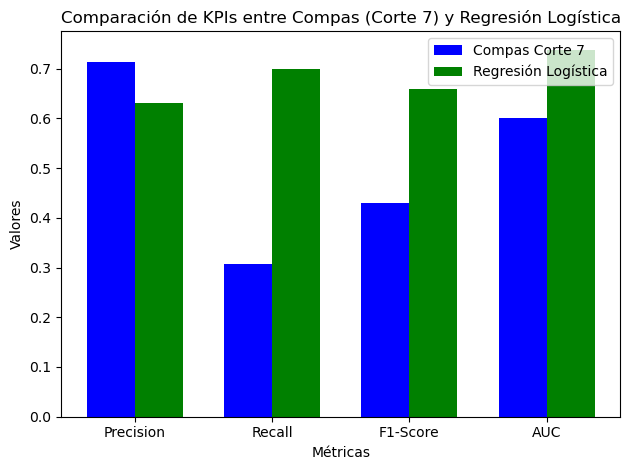

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# KPIs del modelo Compas (punto de corte 7)
kpis_compas_7 = {
    "Precision": 0.7134711332858161,
    "Recall": 0.3079052599200246,
    "F1-Score": 0.4301675977653631,
    "AUC": 0.60
}

# KPIs del modelo de Regresión Logística
kpis_log_reg = {
    "Precision": 0.63,  # del conjunto de prueba
    "Recall": 0.70,     # del conjunto de prueba
    "F1-Score": 0.66,   # del conjunto de prueba
    "AUC": 0.7380887931049392  # AUC en el conjunto de prueba
}

# Comparar los valores de KPIs en un gráfico
metrics = ["Precision", "Recall", "F1-Score", "AUC"]
values_compas_7 = [kpis_compas_7[metric] for metric in metrics]
values_log_reg = [kpis_log_reg[metric] for metric in metrics]

# Crear la gráfica comparativa
bar_width = 0.35
index = np.arange(len(metrics))

fig, ax = plt.subplots()

# Barras para el modelo Compas (corte 7)
bars_compas = ax.bar(index, values_compas_7, bar_width, label='Compas Corte 7', color='blue')

# Barras para el modelo de Regresión Logística
bars_log_reg = ax.bar(index + bar_width, values_log_reg, bar_width, label='Regresión Logística', color='green')

# Añadir etiquetas y título
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de KPIs entre Compas (Corte 7) y Regresión Logística')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


Interpretación:

1. Precisión:

Compas (Corte 7): 71.3%

Regresión Logística: 63%

Interpretación: El modelo de Compas con corte en 7 tiene una mejor precisión, lo que significa que cuando predice a alguien como de alto riesgo, es más probable que sea correcto. Sin embargo, esta alta precisión se debe a que Compas tiene un punto de corte más alto, lo que lo hace más conservador, pero menos inclusivo.

2. Recall (Sensibilidad):

Compas (Corte 7): 30.8%

Regresión Logística: 70%

Interpretación: El modelo de Regresión Logística tiene un mejor recall, lo que significa que captura una mayor cantidad de reincidentes. El corte más conservador de Compas en 7 tiene un recall bajo, lo que indica que deja fuera a muchos reincidentes (falsos negativos).

3. F1-Score:

Compas (Corte 7): 43%

Regresión Logística: 66%

Interpretación: El F1-Score de la Regresión Logística es significativamente mejor, lo que indica que este modelo encuentra un mejor equilibrio entre precisión y recall. El modelo Compas es menos equilibrado, con un bajo recall que afecta su F1-Score.

4. AUC:

Compas (Corte 7): 0.60

Regresión Logística: 0.74

Interpretación: El AUC del modelo de Regresión Logística es claramente mejor, lo que sugiere que el modelo tiene una mayor capacidad para distinguir entre reincidentes y no reincidentes en términos generales. El AUC del modelo Compas en el punto de corte 7 es más bajo, lo que refleja su bajo recall y capacidad limitada de diferenciación.

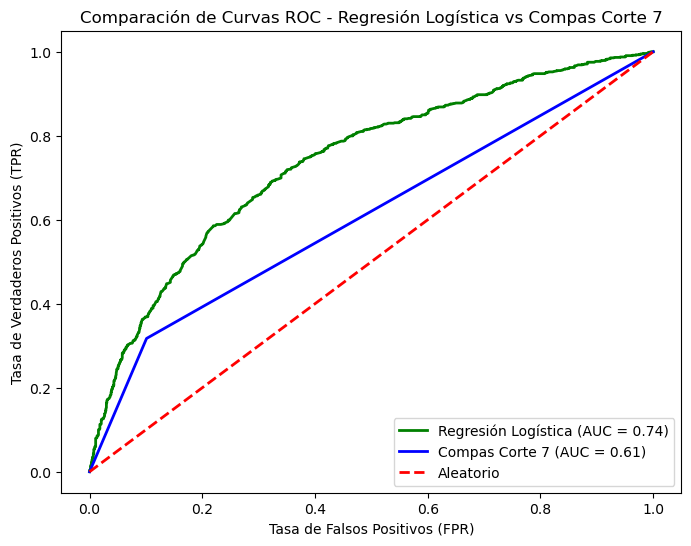

AUC Regresión Logística: 0.74
AUC Compas Corte 7: 0.61


In [9]:
# Filtrar las predicciones de Compas para que coincidan con el conjunto de prueba
y_prob_compas_7_test = df_compas_2y_clean.loc[X_test.index, 'decile_score']

# Calcular la curva ROC para el modelo Compas (corte en 7)
fpr_compas_7, tpr_compas_7, _ = roc_curve(y_test, y_prob_compas_7_test > 7)
roc_auc_compas_7 = auc(fpr_compas_7, tpr_compas_7)

# Calcular la curva ROC para el modelo de Regresión Logística
y_prob_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Crear el gráfico comparativo de las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='green', lw=2, label=f'Regresión Logística (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_compas_7, tpr_compas_7, color='blue', lw=2, label=f'Compas Corte 7 (AUC = {roc_auc_compas_7:.2f})')

# Línea base de no discriminación
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Aleatorio')

# Añadir etiquetas y título
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC - Regresión Logística vs Compas Corte 7')
plt.legend(loc="lower right")
plt.show()

# Imprimir los AUC de ambos modelos
print(f"AUC Regresión Logística: {roc_auc_log_reg:.2f}")
print(f"AUC Compas Corte 7: {roc_auc_compas_7:.2f}")


## Creación del Dataframe de test con las probabilidades predichas por el modelo generado

In [10]:
# Obtener las probabilidades predichas por el modelo de regresión logística original
y_prob_log_reg_test = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probabilidad de la clase 1 (reincidente)

# Crear una copia del dataframe de prueba para agregar la columna con las probabilidades
df_test_with_probs = df_compas_2y_clean.loc[X_test.index].copy()

# Agregar la columna de predicciones probabilísticas
df_test_with_probs['log_reg_probabilities'] = y_prob_log_reg_test

# Mostrar las primeras filas con las predicciones probabilísticas agregadas
print(df_test_with_probs.head())

# Si deseas guardar el resultado en un archivo CSV
df_test_with_probs.to_csv("df_test_with_probabilities.csv", index=False)



        id               name    first       last compas_screening_date  \
308    452         steven lux   steven        lux            2013-01-05   
381    573        andre small    andre      small            2013-04-03   
3238  4952        willie gray   willie       gray            2014-10-31   
2312  3521  nickson marcellus  nickson  marcellus            2014-01-23   
251    369      patria barnes   patria     barnes            2013-12-09   

             dob  age          age_cat  juv_fel_count  decile_score  ...  \
308   1953-06-15   62  Greater than 45              0             1  ...   
381   1987-10-01   28          25 - 45              0             3  ...   
3238  1959-01-12   57  Greater than 45              0             4  ...   
2312  1996-07-11   19     Less than 25              0            10  ...   
251   1978-06-06   37          25 - 45              0             1  ...   

      two_year_recid  race_African-American  race_Asian  race_Caucasian  \
308              

### Creación de columnas de predicción de reincidencia (0,1) en función del corte (0,5 - 0,7) de probabilidad predicha

In [11]:
# Predicción binaria con corte en 0.5
df_test_with_probs['predicted_reincidence_cut_0.5'] = (df_test_with_probs['log_reg_probabilities'] >= 0.5).astype(int)

# Predicción binaria con corte en 0.7
df_test_with_probs['predicted_reincidence_cut_0.7'] = (df_test_with_probs['log_reg_probabilities'] >= 0.7).astype(int)

# Mostrar las primeras filas con las nuevas columnas agregadas
print(df_test_with_probs.head())

# Si deseas guardar el dataframe actualizado en un archivo CSV
df_test_with_probs.to_csv("df_test_with_probabilities_and_predictions.csv", index=False)


        id               name    first       last compas_screening_date  \
308    452         steven lux   steven        lux            2013-01-05   
381    573        andre small    andre      small            2013-04-03   
3238  4952        willie gray   willie       gray            2014-10-31   
2312  3521  nickson marcellus  nickson  marcellus            2014-01-23   
251    369      patria barnes   patria     barnes            2013-12-09   

             dob  age          age_cat  juv_fel_count  decile_score  ...  \
308   1953-06-15   62  Greater than 45              0             1  ...   
381   1987-10-01   28          25 - 45              0             3  ...   
3238  1959-01-12   57  Greater than 45              0             4  ...   
2312  1996-07-11   19     Less than 25              0            10  ...   
251   1978-06-06   37          25 - 45              0             1  ...   

      race_Asian  race_Caucasian  race_Hispanic  race_Native American  \
308        False   

### Compartiva del rendimiento del modelo generado con estos dos puntos de corte

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

# Predicciones originales (y_test) vs corte en 0.5
print("Reporte de clasificación para corte 0.5:")
print(classification_report(y_test, df_test_with_probs['predicted_reincidence_cut_0.5']))

# Predicciones originales (y_test) vs corte en 0.7
print("Reporte de clasificación para corte 0.7:")
print(classification_report(y_test, df_test_with_probs['predicted_reincidence_cut_0.7']))

# Calcular AUC para cada corte
auc_cut_0_5 = roc_auc_score(y_test, df_test_with_probs['predicted_reincidence_cut_0.5'])
auc_cut_0_7 = roc_auc_score(y_test, df_test_with_probs['predicted_reincidence_cut_0.7'])

print(f"AUC para corte 0.5: {auc_cut_0_5}")
print(f"AUC para corte 0.7: {auc_cut_0_7}")


Reporte de clasificación para corte 0.5:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1207
           1       0.63      0.70      0.66       958

    accuracy                           0.68      2165
   macro avg       0.68      0.68      0.68      2165
weighted avg       0.69      0.68      0.68      2165

Reporte de clasificación para corte 0.7:
              precision    recall  f1-score   support

           0       0.61      0.95      0.74      1207
           1       0.80      0.22      0.35       958

    accuracy                           0.63      2165
   macro avg       0.70      0.59      0.55      2165
weighted avg       0.69      0.63      0.57      2165

AUC para corte 0.5: 0.6827275824911397
AUC para corte 0.7: 0.5889072615726286


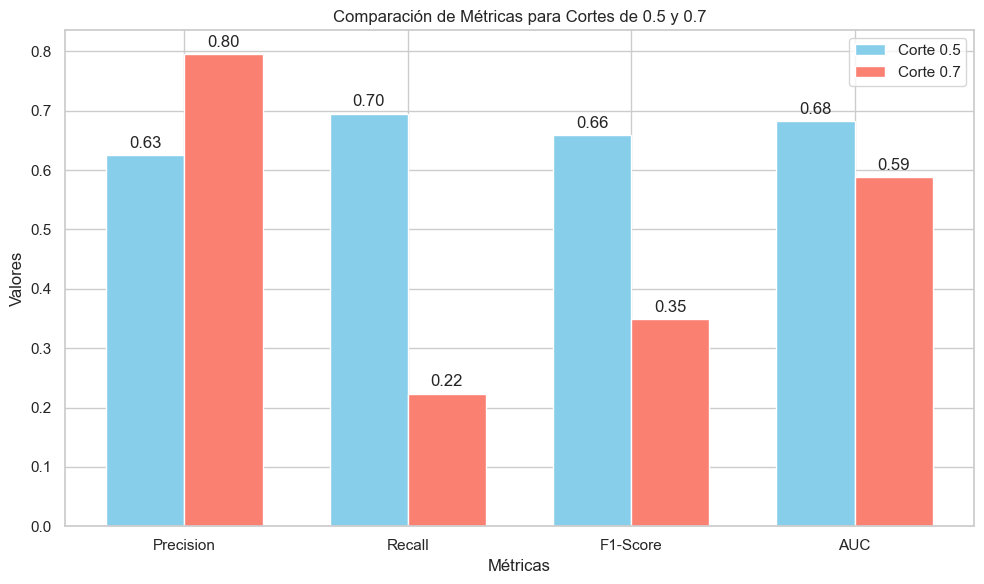

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Extraer los reportes de clasificación como diccionarios
report_cut_0_5 = classification_report(y_test, df_test_with_probs['predicted_reincidence_cut_0.5'], output_dict=True)
report_cut_0_7 = classification_report(y_test, df_test_with_probs['predicted_reincidence_cut_0.7'], output_dict=True)

# Extraer las métricas clave para la clase '1' (la clase positiva de reincidencia)
precision_0_5 = report_cut_0_5['1']['precision']
recall_0_5 = report_cut_0_5['1']['recall']
f1_0_5 = report_cut_0_5['1']['f1-score']

precision_0_7 = report_cut_0_7['1']['precision']
recall_0_7 = report_cut_0_7['1']['recall']
f1_0_7 = report_cut_0_7['1']['f1-score']

# Valores de AUC
auc_cut_0_5 = roc_auc_score(y_test, df_test_with_probs['predicted_reincidence_cut_0.5'])
auc_cut_0_7 = roc_auc_score(y_test, df_test_with_probs['predicted_reincidence_cut_0.7'])

# Crear el DataFrame de métricas
metrics = ['Precision', 'Recall', 'F1-Score', 'AUC']
cut_0_5_values = [precision_0_5, recall_0_5, f1_0_5, auc_cut_0_5]
cut_0_7_values = [precision_0_7, recall_0_7, f1_0_7, auc_cut_0_7]

# Configuración de la gráfica
x = np.arange(len(metrics))  # Posiciones de las métricas
width = 0.35  # Ancho de las barras

# Crear la gráfica comparativa
fig, ax = plt.subplots(figsize=(10, 6))

bars_0_5 = ax.bar(x - width/2, cut_0_5_values, width, label='Corte 0.5', color='skyblue')
bars_0_7 = ax.bar(x + width/2, cut_0_7_values, width, label='Corte 0.7', color='salmon')

# Añadir etiquetas sobre las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Valor que se muestra
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Posición
                    xytext=(0, 3),  # Desplazamiento
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_0_5)
add_labels(bars_0_7)

# Añadir etiquetas y título
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Métricas para Cortes de 0.5 y 0.7')
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Añadir la leyenda
ax.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

Interpretación:

Con un corte en 0.5, el modelo tiene un rendimiento equilibrado entre precisión y recall para ambas clases. La precisión para los no reincidentes es un poco mayor que la de los reincidentes, pero el recall para los reincidentes (70%) indica que el modelo captura una buena cantidad de reincidentes reales. En general, este punto de corte ofrece un buen balance entre evitar falsos negativos (reincidentes no identificados) y falsos positivos (no reincidentes clasificados erróneamente).

Con un corte en 0.7, el modelo tiene una alta precisión (80%) para predecir reincidentes, lo que significa que cuando predice que alguien reincidirá, es más probable que sea correcto. Sin embargo, la sensibilidad (recall) cae drásticamente al 22%, lo que significa que el modelo pierde la mayoría de los reincidentes reales. Este punto de corte es más conservador, priorizando la precisión sobre el recall, y es propenso a producir falsos negativos (reincidentes no identificados).

El AUC del modelo con corte en 0.5 es mejor (0.68) que el de corte en 0.7 (0.59). Esto refleja que el modelo con corte en 0.5 tiene una mejor capacidad de predicción global, mientras que el modelo con corte en 0.7 tiende a perder mucha información de los reincidentes debido a su bajo recall.

### Análisis de Sensibilidad (Trade-off Precision/Recall)

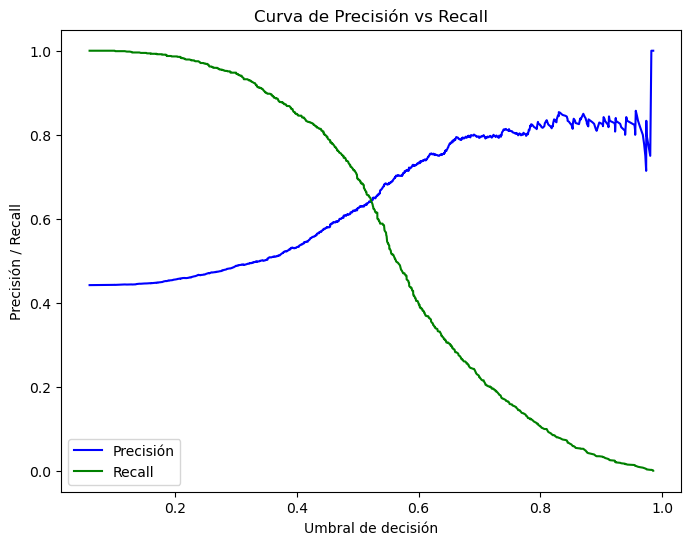

In [13]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calcular la curva de precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, df_test_with_probs['log_reg_probabilities'])

# Graficar la curva precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precisión", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.xlabel('Umbral de decisión')
plt.ylabel('Precisión / Recall')
plt.title('Curva de Precisión vs Recall')
plt.legend()
plt.show()


Conclusión:

Bajo umbral (< 0.5): El modelo captura a la mayoría de los reincidentes (alto recall), pero a costa de una baja precisión (muchos falsos positivos).

Umbral medio (~ 0.5): El modelo mantiene un buen equilibrio entre precisión y recall.

Alto umbral (> 0.5): El modelo es más preciso (menos falsos positivos), pero pierde muchos reincidentes (bajo recall).

### Análisis de Casos Erróneos (False Positives y False Negatives)

In [14]:
# Falsos Positivos y Falsos Negativos para corte 0.5
false_positives_0_5 = df_test_with_probs[(df_test_with_probs['predicted_reincidence_cut_0.5'] == 1) & (y_test == 0)]
false_negatives_0_5 = df_test_with_probs[(df_test_with_probs['predicted_reincidence_cut_0.5'] == 0) & (y_test == 1)]

# Falsos Positivos y Falsos Negativos para corte 0.7
false_positives_0_7 = df_test_with_probs[(df_test_with_probs['predicted_reincidence_cut_0.7'] == 1) & (y_test == 0)]
false_negatives_0_7 = df_test_with_probs[(df_test_with_probs['predicted_reincidence_cut_0.7'] == 0) & (y_test == 1)]

print(f"Falsos Positivos con corte 0.5: {len(false_positives_0_5)}")
print(f"Falsos Negativos con corte 0.5: {len(false_negatives_0_5)}")

print(f"Falsos Positivos con corte 0.7: {len(false_positives_0_7)}")
print(f"Falsos Negativos con corte 0.7: {len(false_negatives_0_7)}")


Falsos Positivos con corte 0.5: 398
Falsos Negativos con corte 0.5: 292
Falsos Positivos con corte 0.7: 55
Falsos Negativos con corte 0.7: 744


Corte en 0.5:

El modelo ofrece un balance razonable entre falsos positivos y falsos negativos, lo que significa que es más capaz de identificar reincidentes correctamente, aunque a costa de tener más falsos positivos.

Corte en 0.7:

El modelo reduce drásticamente los falsos positivos, lo que significa que es muy selectivo a la hora de etiquetar a alguien como reincidente. Sin embargo, esto ocurre a costa de un gran número de falsos negativos, lo que significa que está dejando pasar a muchos reincidentes sin identificarlos.

### Evaluación de Subgrupos Demográficos (Raza, Género)

In [15]:
# Comparar rendimiento entre sexos
print("Rendimiento para sexo masculino (corte 0.5):")
print(classification_report(y_test[df_test_with_probs['sex_Male'] == 1], df_test_with_probs['predicted_reincidence_cut_0.5'][df_test_with_probs['sex_Male'] == 1]))

print("Rendimiento para sexo femenino (corte 0.5):")
print(classification_report(y_test[df_test_with_probs['sex_Female'] == 1], df_test_with_probs['predicted_reincidence_cut_0.5'][df_test_with_probs['sex_Female'] == 1]))

# Comparar rendimiento entre sexos para corte 0.7
print("Rendimiento para sexo masculino (corte 0.7):")
print(classification_report(y_test[df_test_with_probs['sex_Male'] == 1], df_test_with_probs['predicted_reincidence_cut_0.7'][df_test_with_probs['sex_Male'] == 1]))

print("Rendimiento para sexo femenino (corte 0.7):")
print(classification_report(y_test[df_test_with_probs['sex_Male'] == 0], df_test_with_probs['predicted_reincidence_cut_0.7'][df_test_with_probs['sex_Male'] == 0]))



Rendimiento para sexo masculino (corte 0.5):
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       947
           1       0.62      0.75      0.68       821

    accuracy                           0.67      1768
   macro avg       0.68      0.68      0.67      1768
weighted avg       0.68      0.67      0.67      1768

Rendimiento para sexo femenino (corte 0.5):
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       260
           1       0.66      0.36      0.46       137

    accuracy                           0.72       397
   macro avg       0.69      0.63      0.64       397
weighted avg       0.70      0.72      0.69       397

Rendimiento para sexo masculino (corte 0.7):
              precision    recall  f1-score   support

           0       0.59      0.95      0.73       947
           1       0.81      0.25      0.38       821

    accuracy                           0.62     

1. Hombres (Comparación entre Corte 0.5 y 0.7):

Con corte 0.5:

El modelo tiene un buen balance entre precisión y recall. Es capaz de capturar el 75% de los reincidentes masculinos, pero tiene una tasa de falsos positivos algo elevada (precisión en Clase 1 es 0.62).

Con corte 0.7:

El modelo es mucho más conservador, reduce significativamente los falsos positivos (mejora la precisión a 0.81), pero a costa de perder la mayoría de los reincidentes, con un recall de solo 0.25.

Recall en no reincidentes sube mucho (de 0.61 a 0.95), lo que indica que está clasificando casi todos los no reincidentes correctamente, pero con un gran aumento en falsos negativos entre los reincidentes.

Conclusión para hombres:

El corte en 0.5 parece tener un mejor equilibrio entre precisión y recall. Con un corte de 0.7, el modelo reduce drásticamente los falsos positivos pero pierde muchos reincidentes, lo que puede no ser deseable si es importante capturar la mayoría de los reincidentes.

2. Mujeres (Comparación entre Corte 0.5 y 0.7):

Con corte 0.5:

El modelo captura el 36% de las reincidentes con una precisión de 0.66, lo que sugiere que tiene una tasa moderada de falsos negativos y falsos positivos.

Con corte 0.7:

El modelo reduce mucho los falsos positivos (precisión en Clase 1 baja a 0.54), pero solo identifica el 5% de las reincidentes (recall de 0.05), lo que es extremadamente bajo.
En cambio, la precisión en no reincidentes mejora (de 0.90 a 0.98), lo que indica que el modelo predice correctamente casi todos los no reincidentes femeninos.

Conclusión para mujeres:

Con un corte de 0.7, el modelo se vuelve demasiado conservador, lo que significa que prácticamente no está capturando a las reincidentes (solo un 5% de recall). El corte de 0.5 es más equilibrado, con mejor capacidad para identificar reincidentes, aunque tiene más falsos positivos.

Conclusión Global:

Corte 0.5:

Ofrece un mejor balance entre precisión y recall para ambos sexos.

Para los hombres, captura bien a los reincidentes (75% recall), aunque tiene algo de margen para mejorar en falsos positivos.
Para las mujeres, captura más reincidentes (36%) en comparación con el corte 0.7, aunque sigue presentando desafíos para reducir los falsos negativos.

Corte 0.7:

Reduce los falsos positivos, pero a costa de perder a la mayoría de los reincidentes.
Para los hombres, el recall cae al 25%, lo que implica que se identifican pocos reincidentes.
Para las mujeres, el modelo es extremadamente conservador, solo capturando el 5% de las reincidentes, lo que lo hace poco útil para este subgrupo en términos de capturar reincidencia.

Recomendación:

Si el objetivo es capturar la mayor cantidad de reincidentes y evitar falsos negativos, el corte de 0.5 parece más adecuado para ambos géneros. El corte de 0.7 puede ser útil si minimizar los falsos positivos es la prioridad, pero es probable que muchos reincidentes no sean identificados.

### Otros análisis del modelo

#### 1. Probabilidad AUC ROC de los 5 Delitos más comunes

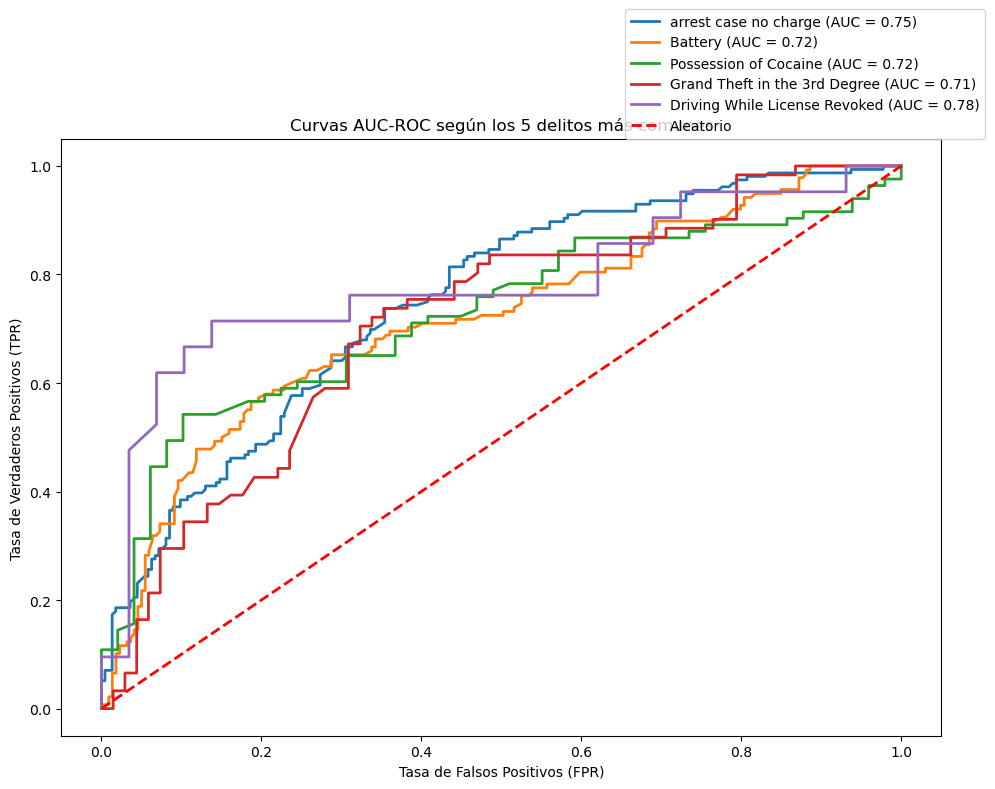

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Contar la frecuencia de cada delito y seleccionar los 20 más comunes
top_5_delitos = df_test_with_probs['c_charge_desc'].value_counts().nlargest(5).index

# Crear el gráfico
plt.figure(figsize=(10, 8))

# Iterar sobre los 20 delitos más comunes y calcular la curva ROC
for delito in top_5_delitos:
    # Filtrar las filas correspondientes al delito actual
    df_delito = df_test_with_probs[df_test_with_probs['c_charge_desc'] == delito]
    
    # Asegurarse de que haya suficientes datos para calcular el ROC
    if len(df_delito) > 1:  # Evita delitos con muy pocos casos
        
        # Obtener las etiquetas reales (reincidencia o no)
        y_true = y_test.loc[df_delito.index]
        
        # Obtener las probabilidades predichas por el modelo de regresión logística
        y_prob = df_delito['log_reg_probabilities']
        
        # Calcular la curva ROC
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Graficar la curva ROC para este delito
        plt.plot(fpr, tpr, lw=2, label=f'{delito} (AUC = {roc_auc:.2f})')

# Añadir la línea base (curva ROC aleatoria)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Aleatorio')

# Añadir etiquetas y leyenda
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas AUC-ROC según los 5 delitos más comunes')
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


Análisis por cada delito:

Conducir con la licencia revocada  (AUC = 0.78):

AUC más alto (0.78): El modelo tiene un buen rendimiento para predecir reincidencia en este delito. Se acerca más a la esquina superior izquierda de la gráfica, lo que indica una mayor tasa de verdaderos positivos para una menor tasa de falsos positivos.
Esto significa que el modelo es mejor discriminando entre reincidentes y no reincidentes para este delito en particular.

Caso de arresto sin cargos  (AUC = 0.75):

AUC alto (0.75): También muestra un buen rendimiento, cercano al de "Driving While License Revoked". El modelo es capaz de identificar correctamente a la mayoría de los reincidentes y tiene una baja tasa de falsos positivos.
La curva está consistentemente por encima de la línea aleatoria, lo que indica una buena capacidad de discriminación.

Agresión (AUC = 0.72) y Posesión de cocaína (AUC = 0.72):

Ambos delitos tienen AUC similares (0.72), lo que indica un rendimiento aceptable para predecir la reincidencia.

Estas curvas muestran un equilibrio moderado entre verdaderos positivos y falsos positivos, pero no son tan fuertes como los dos delitos anteriores. Aunque el modelo tiene capacidad para identificar reincidentes, podría mejorar.

Gran robo en tercer grado  (AUC = 0.71):

AUC más bajo (0.71): Aunque sigue siendo un rendimiento decente, es el más bajo entre los cinco delitos.

Esto significa que el modelo tiene más problemas para predecir reincidencia en este tipo de delito. Podría haber más falsos negativos o falsos positivos comparado con los otros delitos.

Conclusiones Generales:

Conducir con la licencia revocada y Caso de arresto sin cargos son los delitos para los cuales el modelo de regresión tiene el mejor rendimiento en términos de discriminación entre reincidentes y no reincidentes.

Agresión y Posesión de cocaína tienen un rendimiento aceptable, pero con algo más de margen de mejora.

Gran robo en tercer grado es el delito donde el modelo tiene el peor rendimiento relativo entre los 5 más comunes. Aunque el AUC sigue siendo aceptable (>0.7), podría sugerir que el modelo no distingue tan bien entre reincidentes y no reincidentes en estos casos.

#### 2. Probabilidad AUC ROC en función de Número de delitos anteriores

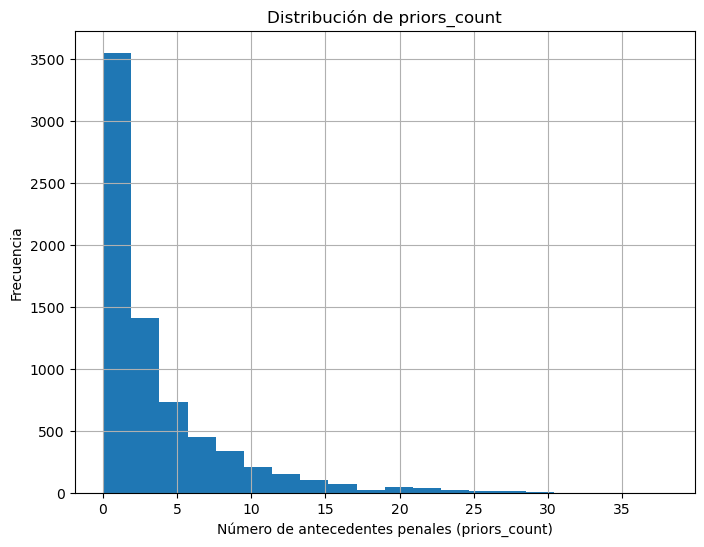

In [17]:
import matplotlib.pyplot as plt

# Crear un histograma de priors_count
plt.figure(figsize=(8, 6))
df_compas_2y['priors_count'].hist(bins=20)  # Puedes ajustar el número de bins si lo deseas
plt.xlabel('Número de antecedentes penales (priors_count)')
plt.ylabel('Frecuencia')
plt.title('Distribución de priors_count')
plt.show()


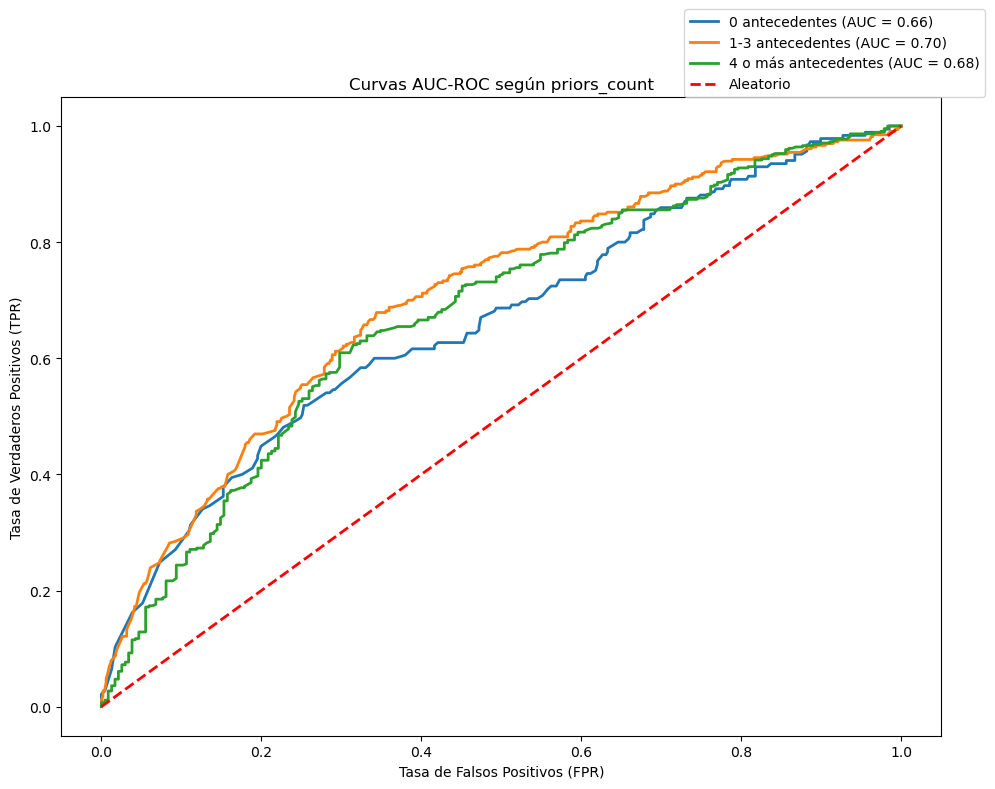

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Definir grupos de priors_count
df_test_with_probs['priors_group'] = pd.cut(df_test_with_probs['priors_count'],
                                            bins=[-1, 0, 3, float('inf')],
                                            labels=['0 antecedentes', '1-3 antecedentes', '4 o más antecedentes'])

# Crear el gráfico
plt.figure(figsize=(10, 8))

# Iterar sobre cada grupo de priors_count y calcular la curva ROC
for grupo in df_test_with_probs['priors_group'].unique():
    # Filtrar las filas correspondientes al grupo actual
    df_grupo = df_test_with_probs[df_test_with_probs['priors_group'] == grupo]
    
    # Asegurarse de que haya suficientes datos para calcular el ROC
    if len(df_grupo) > 1:  # Evita grupos con muy pocos casos
        
        # Obtener las etiquetas reales (reincidencia o no)
        y_true = y_test.loc[df_grupo.index]
        
        # Obtener las probabilidades predichas por el modelo de regresión logística
        y_prob = df_grupo['log_reg_probabilities']
        
        # Calcular la curva ROC
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Graficar la curva ROC para este grupo
        plt.plot(fpr, tpr, lw=2, label=f'{grupo} (AUC = {roc_auc:.2f})')

# Añadir la línea base (curva ROC aleatoria)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Aleatorio')

# Añadir etiquetas y leyenda
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas AUC-ROC según priors_count')
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


Conclusiones:

Mejor rendimiento para personas con 1-3 antecedentes:

El modelo tiene el mejor rendimiento (AUC = 0.70) para predecir reincidencia en personas con 1-3 antecedentes penales. Esto significa que el modelo tiene una mejor capacidad para discriminar entre reincidentes y no reincidentes en este grupo.

Dificultades en los extremos (0 y 4+ antecedentes):

Para personas sin antecedentes penales (AUC = 0.66) y personas con muchos antecedentes (AUC = 0.68), el rendimiento es moderado, lo que sugiere que el modelo tiene más dificultades para hacer predicciones precisas en estos casos.

En el caso de 0 antecedentes, puede ser más difícil para el modelo identificar reincidentes ya que no hay un historial de comportamiento previo para evaluar.

Similitud entre 0 y 4+ antecedentes:

Los valores de AUC son muy similares entre 0 antecedentes y 4 o más antecedentes. Esto sugiere que el modelo no tiene un comportamiento marcadamente mejor ni peor en estos extremos, pero sigue sin ser tan eficiente como en el grupo intermedio.

Interpretación

En términos de predicción, el modelo tiene su mejor rendimiento en personas con algunos antecedentes (1-3), lo cual tiene sentido, ya que este grupo podría ser más fácil de predecir debido a su historial limitado de reincidencia.

El modelo tiene más dificultades para predecir correctamente la reincidencia en personas sin antecedentes o con muchos antecedentes, lo que podría requerir mejoras en el modelo o el uso de más características para capturar mejor estos casos.